In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

In [2]:
# Tinggi dan lebar untuk mengubah ukuran frame video
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224

# Jumlah frame yang akan diambil dari setiap video
SEQUENCE_LENGTH = 16

# Direktori tempat dataset disimpan
DATASET_DIR = "../data/"

# Daftar class untuk klasifikasi
CLASSES_LIST = ["NonViolence", "Violence"]

In [3]:
X_train = np.load(DATASET_DIR + "ProcessedData/X_train.npy")
X_test = np.load(DATASET_DIR + "ProcessedData/X_test.npy")
y_train = np.load(DATASET_DIR + "ProcessedData/y_train.npy")
y_test = np.load(DATASET_DIR + "ProcessedData/y_test.npy")

In [4]:
base_model = tf.keras.applications.MobileNetV2( include_top=False , weights="imagenet", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

In [5]:
inp = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x   = TimeDistributed(base_model)(inp)
x   = Dropout(0.25)(x)
x   = TimeDistributed(GlobalAveragePooling2D())(x)

# 2) Sequence encoder
x   = Bidirectional(LSTM(32), backward_layer=LSTM(32, go_backwards=True))(x)
x   = Dropout(0.25)(x)

# 3) Classifier head
for units in [256, 128, 64, 32]:
    x = Dense(units, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

out = Dense(len(CLASSES_LIST), activation='softmax')(x)

model = Model(inp, out)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 7, 7, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 7, 7, 1280) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │       336,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,655,970 (10.13 MB)

 Trainable params: 2,078,562 (7.93 MB)

 Non-trainable params: 577,408 (2.20 MB)

In [6]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6,
    patience=5,
    min_lr=5e-5,
    verbose=1
)

checkpoint = ModelCheckpoint(
    '../models/MobileNetV2_BiLSTM_best.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [7]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size=8,
    epochs=50,
    shuffle=True,  
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5189 - loss: 1.1261
Epoch 1: val_loss improved from inf to 0.65639, saving model to ../models/MobileNetV2_BiLSTM_best.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.5191 - loss: 1.1254 - val_accuracy: 0.6278 - val_loss: 0.6564 - learning_rate: 0.0010
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5814 - loss: 0.8176
Epoch 2: val_loss improved from 0.65639 to 0.40437, saving model to ../models/MobileNetV2_BiLSTM_best.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.5816 - loss: 0.8173 - val_accuracy: 0.8472 - val_loss: 0.4044 - learning_rate: 0.0010
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7161 - loss: 0.5972
Epoch 3: val_loss did not improve from 0.40437
180/180 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.7161 - loss: 0.5972 - val_accuracy: 0.6528 - val_loss: 0.7823 - learning_rate: 0.0010
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7753 - loss: 0.4896
Epoch 4: val_loss improved from 0.40437 to 0.37176, saving model to ../models/MobileNetV2_BiLSTM_best.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.7753 - loss: 0.4895 - val_accuracy: 0.8528 - val_loss: 0.3718 - learning_rate: 0.0010
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7665 - loss: 0.4969
Epoch 5: val_loss improved from 0.37176 to 0.36915, saving model to ../models/MobileNetV2_BiLSTM_best.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.7665 - loss: 0.4968 - val_accuracy: 0.8333 - val_loss: 0.3691 - learning_rate: 0.0010
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7938 - loss: 0.4580
Epoch 6: val_loss improved from 0.36915 to 0.29448, saving model to ../models/MobileNetV2_BiLSTM_best.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.7938 - loss: 0.4580 - val_accuracy: 0.9139 - val_loss: 0.2945 - learning_rate: 0.0010
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8336 - loss: 0.4079
Epoch 7: val_loss did not improve from 0.29448
180/180 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.8336 - loss: 0.4078 - val_accuracy: 0.8917 - val_loss: 0.3017 - learning_rate: 0.0010
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8452 - loss: 0.3450
Epoch 8: val_loss improved from 0.29448 to 0.28274, saving model to ../models/MobileNetV2_BiLSTM_best.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.8453 - loss: 0.3451 - val_accuracy: 0.8694 - val_loss: 0.2827 - learning_rate: 0.0010
Epoch 9/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8378 - loss: 0.3708
Epoch 9: val_loss improved from 0.28274 to 0.22899, saving model to ../models/MobileNetV2_BiLSTM_best.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.8378 - loss: 0.3706 - val_accuracy: 0.9139 - val_loss: 0.2290 - learning_rate: 0.0010
Epoch 10/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8672 - loss: 0.3207
Epoch 10: val_loss improved from 0.22899 to 0.17589, saving model to ../models/MobileNetV2_BiLSTM_best.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.8673 - loss: 0.3207 - val_accuracy: 0.9611 - val_loss: 0.1759 - learning_rate: 0.0010
Epoch 11/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8802 - loss: 0.2887
Epoch 11: val_loss did not improve from 0.17589
180/180 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.8802 - loss: 0.2887 - val_accuracy: 0.8500 - val_loss: 0.4180 - learning_rate: 0.0010
Epoch 12/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8724 - loss: 0.3074
Epoch 12: val_loss did not improve from 0.17589
180/180 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.8725 - loss: 0.3074 - val_accuracy: 0.9472 - val_loss: 0.1880 - learning_rate: 0.0010
Epoch 13/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9189 - loss: 0.2269
Epoch 13: val_loss improved from 0.17589 to 0.15856, saving model to ../models/MobileNetV2_BiLSTM_best.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.9189 - loss: 0.2269 - val_accuracy: 0.9583 - val_loss: 0.1586 - learning_rate: 0.0010
Epoch 14/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9057 - loss: 0.2473
Epoch 14: val_loss did not improve from 0.15856
180/180 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.9057 - loss: 0.2473 - val_accuracy: 0.8972 - val_loss: 0.2404 - learning_rate: 0.0010
Epoch 15/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8844 - loss: 0.2973
Epoch 15: val_loss did not improve from 0.15856
180/180 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.8844 - loss: 0.2972 - val_accuracy: 0.9000 - val_loss: 0.2734 - learning_rate: 0.0010
Epoch 16/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8967 - loss: 0.2439
Epoch 16: val_loss improved from 0.15856 to 0.14258, saving model to ../models/MobileNetV2_BiLSTM_best.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.8967 - loss: 0.2440 - val_accuracy: 0.9472 - val_loss: 0.1426 - learning_rate: 0.0010
Epoch 17/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9136 - loss: 0.2185
Epoch 17: val_loss improved from 0.14258 to 0.14048, saving model to ../models/MobileNetV2_BiLSTM_best.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.9136 - loss: 0.2185 - val_accuracy: 0.9500 - val_loss: 0.1405 - learning_rate: 0.0010
Epoch 18/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9128 - loss: 0.2748
Epoch 18: val_loss did not improve from 0.14048
180/180 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.9128 - loss: 0.2746 - val_accuracy: 0.9167 - val_loss: 0.2272 - learning_rate: 0.0010
Epoch 19/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9138 - loss: 0.2091
Epoch 19: val_loss did not improve from 0.14048
180/180 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.9138 - loss: 0.2091 - val_accuracy: 0.9250 - val_loss: 0.2211 - learning_rate: 0.0010
Epoch 20/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9322 - loss: 0.2009
Epoch 20: val_loss did not improve from 0.14048
180/180 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.9322 - loss: 0.2010 - val_accuracy: 0.8917 - val_loss: 0.3269 - learning_rate: 0.0010
Epoch 21/50
180/180 ━━━━━━━━━━

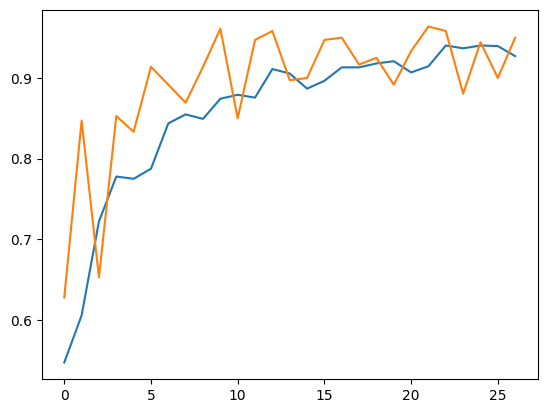

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [9]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Get the Epochs Count
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

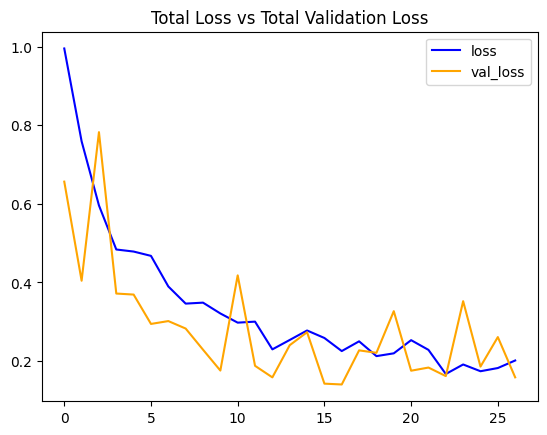

In [10]:
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [11]:
y_predict = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step


In [12]:
# Decoding the data to use in Metrics
y_predict = np.argmax(y_predict , axis=1)
y_test_normal = np.argmax(y_test , axis=1)

In [13]:
y_test_normal.shape , y_predict.shape

((200,), (200,))

In [14]:
acc_score = accuracy_score(y_predict, y_test_normal)
print('Accuracy Score is : ', acc_score)

Accuracy Score is :  0.935


[Text(0, 0.5, 'NonViolence'), Text(0, 1.5, 'Violence')]

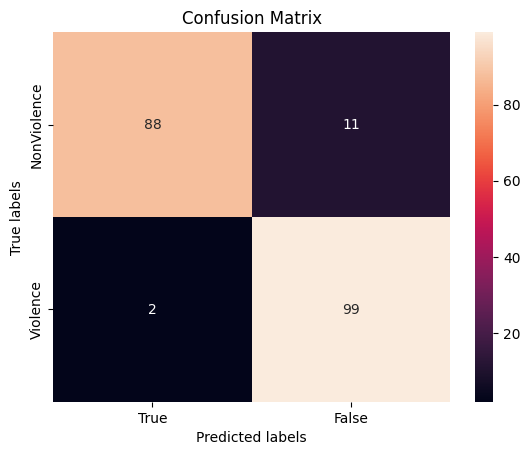

In [15]:
import seaborn as sns
ax= plt.subplot()
cm=confusion_matrix(y_test_normal, y_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence'])